# 1. 모델 가져오기

## 1) 라이브러리

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import json
import random
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

Mounted at /content/drive


## 2) deep-text-recognition-benchmark 오픈소스 가져오기 및 작업환경 구축

In [ ]:
%cd /content
!git clone https://github.com/Solxcero/-deep-text-recognition-benchmark.git
%cd /content/-deep-text-recognition-benchmark/
!mkdir data
%cd /content/-deep-text-recognition-benchmark/data
!mkdir train
!mkdir test
!mkdir validation

/content
Cloning into '-deep-text-recognition-benchmark'...
remote: Enumerating objects: 62, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 62 (delta 24), reused 52 (delta 14), pack-reused 0
Unpacking objects: 100% (62/62), done.
/content/-deep-text-recognition-benchmark
/content/-deep-text-recognition-benchmark/data


## 3) 작업환경에 이미지파일 압축 풀기
* 인쇄체 문장 25000번 학습한 모델에 손글씨 문장 전이학습 예정  
    - 손글씨 문장 이미지 사용

In [ ]:
%cd /content/-deep-text-recognition-benchmark/data/
!unzip '/content/drive/MyDrive/team/★최고은진★/딥러닝_프로젝트_최고은진조_최종제출/hadwriting/1_handwriting_sentence_images.zip'

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: 1_handwriting_sentence_images/1_sentence/01073367.png  
  inflating: 1_handwriting_sentence_images/1_sentence/01073368.png  
  inflating: 1_handwriting_sentence_images/1_sentence/01073369.png  
  inflating: 1_handwriting_sentence_images/1_sentence/01073370.png  
  inflating: 1_handwriting_sentence_images/1_sentence/01073371.png  
  inflating: 1_handwriting_sentence_images/1_sentence/01073372.png  
  inflating: 1_handwriting_sentence_images/1_sentence/01073373.png  
  inflating: 1_handwriting_sentence_images/1_sentence/01073374.png  
  inflating: 1_handwriting_sentence_images/1_sentence/01073375.png  
  inflating: 1_handwriting_sentence_images/1_sentence/01073376.png  
  inflating: 1_handwriting_sentence_images/1_sentence/01073377.png  
  inflating: 1_handwriting_sentence_images/1_sentence/01073378.png  
  inflating: 1_handwriting_sentence_images/1_sentence/01073379.png  
  inflating: 1_handwriting_sentence_images/1_sentence/01073380.png 

# 2. 데이터 전처리 과정

## 1) 이미지 정보가 들어있는 json 파일 가져오기

In [ ]:
file = json.load(open('/content/drive/MyDrive/team/★최고은진★/딥러닝_프로젝트_최고은진조_최종제출/hadwriting/handwriting_data_info_clean.json'))
file.keys() #dict_keys(['info', 'images', 'annotations', 'licenses'])

# json 파일 정보 확인
file['info'] #{'name': 'Text in the wild Dataset', 'date_created': '2019-10-14 04:31:48'}
type(file['images']) #list

list

## 2) json 정보에서 학습에 필요한 '문장' 이미지 정보 가져와서 저장하기

In [ ]:
# json 데이터 정보 확인
syllables = [f for f in file['annotations'] if f['attributes']['type'] == '글자(음절)']
words = [f for f in file['annotations'] if f['attributes']['type'] == '단어(어절)']
sentences = [f for f in file['annotations'] if f['attributes']['type'] == '문장']
images = [f for f in file['images']]

print(len(syllables), len(words), len(sentences), len(images))
#729248 359997 52800 1142045

729248 359997 52800 1142045


## 3) 데이터 분할하기

In [ ]:
# train, valid, test 데이터 나누기

ocr_sentences_files = os.listdir('/content/-deep-text-recognition-benchmark/data/1_handwriting_sentence_images/1_sentence')
len(ocr_sentences_files)  # 52800

random.seed(1000)
random.shuffle(ocr_sentences_files)

n_train = int(len(ocr_sentences_files) * 0.8) 
n_validation = int(len(ocr_sentences_files) * 0.1)
n_test = int(len(ocr_sentences_files) * 0.1)

print(len(ocr_sentences_files) )
print(n_train, n_validation, n_test) # 42240 5280 5280

52800
42240 5280 5280


* 데이터 세트별 id값을 저장하고, 해당하는 annotation을 json으로 저장

In [ ]:
train_files = ocr_sentences_files[:n_train]
validation_files = ocr_sentences_files[n_train: n_train+n_validation]
test_files = ocr_sentences_files[-n_test:]

## train/validation/test 이미지들에 해당하는 id 값을 저장

train_img_ids = {}
validation_img_ids = {}
test_img_ids = {}

for image in file['images']:
    if image['file_name'] in train_files:
        train_img_ids[image['file_name']] = image['id']
    elif image['file_name'] in validation_files:
        validation_img_ids[image['file_name']] = image['id']
    elif image['file_name'] in test_files:
        test_img_ids[image['file_name']] = image['id']

## train/validation/test 이미지들에 해당하는 annotation 들을 저장

train_annotations = {f:[] for f in train_img_ids.keys()}
validation_annotations = {f:[] for f in validation_img_ids.keys()}
test_annotations = {f:[] for f in test_img_ids.keys()}

train_ids_img = {train_img_ids[id_]:id_ for id_ in train_img_ids}
validation_ids_img = {validation_img_ids[id_]:id_ for id_ in validation_img_ids}
test_ids_img = {test_img_ids[id_]:id_ for id_ in test_img_ids}

for idx, annotation in enumerate(file['annotations']):
    if idx % 5000 == 0:
        print(idx,'/',len(file['annotations']),'processed')
    if annotation['attributes']['type'] != '문장':
        continue
    if annotation['image_id'] in train_ids_img:
        train_annotations[train_ids_img[annotation['image_id']]].append(annotation)
    elif annotation['image_id'] in validation_ids_img:
        validation_annotations[validation_ids_img[annotation['image_id']]].append(annotation)
    elif annotation['image_id'] in test_ids_img:
        test_annotations[test_ids_img[annotation['image_id']]].append(annotation)

with open('train_annotation.json', 'w') as file:
    json.dump(train_annotations, file)
with open('validation_annotation.json', 'w') as file:
    json.dump(validation_annotations, file)
with open('test_annotation.json', 'w') as file:
    json.dump(test_annotations, file)

* lmdb 파일 생성에 사용할 txt 파일 준비

In [ ]:
import json
import os
import cv2
import matplotlib.pyplot as plt

## aihub 데이터 annotation을 읽어서 단어 단위로 잘라서 data에 저장하기

data_root_path = '/content/-deep-text-recognition-benchmark/data/1_handwriting_sentence_images/1_sentence/'
save_root_path = '/content/-deep-text-recognition-benchmark/data/'

test_annotations = json.load(open('/content/-deep-text-recognition-benchmark/data/test_annotation.json'))
gt_file = open(save_root_path+'gt_test.txt', 'w')
for file_name in tqdm(test_annotations):
    annotations = test_annotations[file_name]
    image = cv2.imread(data_root_path+file_name)
    
    text = annotations[0]['text']      
    cv2.imwrite(save_root_path+'test/'+file_name,image)
    gt_file.write("test/{}\t{}\n".format(file_name, text))
    

validation_annotations = json.load(open('/content/-deep-text-recognition-benchmark/data/validation_annotation.json'))
gt_file = open(save_root_path+'gt_validation.txt', 'w')
for file_name in tqdm(validation_annotations):
    annotations = validation_annotations[file_name]
    image = cv2.imread(data_root_path+file_name)
    
    text = annotations[0]['text']
       
    cv2.imwrite(save_root_path+'validation/'+file_name,image )
    gt_file.write("validation/{}\t{}\n".format(file_name, text))
        
train_annotations = json.load(open('/content/-deep-text-recognition-benchmark/data/train_annotation.json'))
gt_file = open(save_root_path+'gt_train.txt', 'w')
for file_name in tqdm(train_annotations):
    annotations = train_annotations[file_name]
    image = cv2.imread(data_root_path+file_name)
   
    text = annotations[0]['text']
       
    cv2.imwrite(save_root_path+'train/'+file_name,image)
    gt_file.write("train/{}\t{}\n".format(file_name, text))

100%|██████████| 5280/5280 [02:31<00:00, 34.82it/s]


# 모델 학습

In [ ]:
!pip install lmdb
!pip install fire
import fire
import cv2
import lmdb,torch,torchvision, nltk ,natsort

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 7.3 MB/s 
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116949 sha256=aaecf786317983930cf69686e42b293283012e793f37f390e76e67b99b096fc5
  Stored in directory: /root/.cache/pip/wheels/5b/eb/43/7295e71293b218ddfd627f935229bf54af9018add7fbb5aac6
Successfully built fire


In [ ]:
%cd /content/-deep-text-recognition-benchmark

/content/-deep-text-recognition-benchmark
/content/-deep-text-recognition-benchmark


In [ ]:
# train, validation lmdb 형성
!python3 create_lmdb_dataset.py --inputPath data/ --gtFile data/gt_train.txt --outputPath data_lmdb/train
!python3 create_lmdb_dataset.py --inputPath data/ --gtFile data/gt_validation.txt --outputPath data_lmdb/validation

## 전이학습
* 학습된 모델 불러오기 (인쇄체 문장 약 4만개에 대한 25000번 학습 실시한 모델)  
    → 손글씨 문장 약 5만개에 대한 15000번 학습 실시

* 제출한 모델은 **최종 전이학습 완료된 모델**입니다.

In [ ]:
!CUDA_VISIBLE_DEVICES=0,1,2 python3 train.py --train_data /content/-deep-text-recognition-benchmark/data_lmdb/train --valid_data /content/-deep-text-recognition-benchmark/data_lmdb/validation/ \
	--saved_model /content/drive/MyDrive/team/한국어글자체/모델/printed_sentence_25000_train_best_accuracy.pth \
	--Transformation TPS --FeatureExtraction ResNet --SequenceModeling BiLSTM --Prediction CTC \
	--data_filtering_off --workers 0 --imgH 64 --imgW 200 --num_iter 10000 --valInterval 1000

--------------------------------------------------------------------------------
dataset_root: /content/-deep-text-recognition-benchmark/data_lmdb/train
opt.select_data: ['/']
opt.batch_ratio: ['1']
--------------------------------------------------------------------------------
dataset_root:    /content/-deep-text-recognition-benchmark/data_lmdb/train	 dataset: /
sub-directory:	/.	 num samples: 42223
num total samples of /: 42223 x 1.0 (total_data_usage_ratio) = 42223
num samples of / per batch: 64 x 1.0 (batch_ratio) = 64
--------------------------------------------------------------------------------
Total_batch_size: 64 = 64
--------------------------------------------------------------------------------
dataset_root:    /content/-deep-text-recognition-benchmark/data_lmdb/validation/	 dataset: /
sub-directory:	/.	 num samples: 5280
--------------------------------------------------------------------------------
model input parameters 64 200 20 1 512 256 1083 50 TPS ResNet BiLSTM CT

In [ ]:
# 최종모델 구글 드라이브 백업
# !cp '/content/-deep-text-recognition-benchmark/saved_models/TPS-ResNet-BiLSTM-CTC-Seed1111/best_accuracy.pth' '/content/drive/MyDrive/team/한국어글자체/모델/sentence_best_accuracy.pth'


# 테스트

## 1) 분리해둔 test 데이터로 테스트
* test.py
* label이 있는 데이터로 문자인식 __정확도__ 확인

In [ ]:
# test lmdb 형성
%cd /content/-deep-text-recognition-benchmark
!python create_lmdb_dataset.py --inputPath data/ --gtFile data/gt_test.txt --outputPath data_lmdb/test

/content/-deep-text-recognition-benchmark
Written 1000 / 5221
Written 2000 / 5221
Written 3000 / 5221
Written 4000 / 5221
Written 5000 / 5221
Created dataset with 5221 samples


In [ ]:
%cd /content/-deep-text-recognition-benchmark

/content/-deep-text-recognition-benchmark


### a. 손글씨 문장 데이터 테스트

In [ ]:
data1 = !CUDA_VISIBLE_DEVICES=0,1,2 python3 test.py --eval_data data_lmdb/test --saved_model /content/-deep-text-recognition-benchmark/saved_models/TPS-ResNet-BiLSTM-CTC-Seed1111/best_accuracy.pth \
   --Transformation TPS --FeatureExtraction ResNet --SequenceModeling BiLSTM --Prediction CTC \
   --data_filtering_off  --workers 0 --imgH 64 --imgW 200

import pandas as pd
c = []
for i in data1[4:]:
  c.append(i.split('|'))
result = pd.DataFrame(c[1:-1], columns=c[0])
result['confidence_score']=round(result['confidence_score'].astype('float'),4)
print('accuracy_score : ',data1[-1])


result.style.background_gradient(cmap='OrRd')

### b. 인쇄체 문장 데이터 테스트

In [ ]:
%cd /content/-deep-text-recognition-benchmark/data/
!unzip '/content/drive/MyDrive/team/★최고은진★/딥러닝_프로젝트_최고은진조_최종제출/printed/01_printed_sentence_images.zip'

In [ ]:
file = json.load(open('/content/drive/MyDrive/team/★최고은진★/딥러닝_프로젝트_최고은진조_최종제출/printed/printed_data_info.json'))
ocr_printed_sentence_files = os.listdir('/content/-deep-text-recognition-benchmark/data/sentence')

random.seed(1000)
random.shuffle(ocr_printed_sentence_files)

n_train = int(len(ocr_printed_sentence_files) * 0.85)
n_validation = int(len(ocr_printed_sentence_files) * 0.1)
n_test = int(len(ocr_printed_sentence_files) * 0.05)


In [ ]:
# 나눠진 파일명 객체에 저장

test_files = ocr_printed_sentence_files[-n_test:]

## train/validation/test 이미지들에 해당하는 id 값을 저장

test_img_ids = {}

for image in file['images']:
    if image['file_name'] in test_files:
        test_img_ids[image['file_name']] = image['id']


## train/validation/test 이미지들에 해당하는 annotation 들을 저장

test_annotations = {f:[] for f in test_img_ids.keys()}

test_ids_img = {test_img_ids[id_]:id_ for id_ in test_img_ids}

for idx, annotation in enumerate(file['annotations']):
    if idx % 5000 == 0:
        print(idx,'/',len(file['annotations']),'processed')
    if annotation['attributes']['type'] != '문장':
        continue
    elif annotation['image_id'] in test_ids_img:
        test_annotations[test_ids_img[annotation['image_id']]].append(annotation)

with open('test_annotation.json', 'w') as file:
    json.dump(test_annotations, file)

data_root_path = '/content/-deep-text-recognition-benchmark/data/sentence/'
save_root_path = '/content/-deep-text-recognition-benchmark/data/'

test_annotations = json.load(open('/content/-deep-text-recognition-benchmark/data/test_annotation.json'))
gt_file = open(save_root_path+'gt_test_2.txt', 'w')
for file_name in tqdm(test_annotations):
    annotations = test_annotations[file_name]
    image = cv2.imread(data_root_path+file_name)
    
    text = annotations[0]['text']      
    cv2.imwrite(save_root_path+'test/'+file_name,image)
    gt_file.write("test/{}\t{}\n".format(file_name, text))

In [ ]:
%cd /content/-deep-text-recognition-benchmark
!python create_lmdb_dataset.py --inputPath data/ --gtFile data/gt_test_2.txt --outputPath data_lmdb/test

/content/-deep-text-recognition-benchmark
Written 1000 / 1988
Created dataset with 1988 samples


In [ ]:
data2 = !CUDA_VISIBLE_DEVICES=0,1,2 python3 test.py --eval_data data_lmdb/test --saved_model /content/-deep-text-recognition-benchmark/saved_models/TPS-ResNet-BiLSTM-CTC-Seed1111/best_accuracy.pth \
   --Transformation TPS --FeatureExtraction ResNet --SequenceModeling BiLSTM --Prediction CTC \
   --data_filtering_off  --workers 0 --imgH 64 --imgW 200

c = []
for i in data2[4:]:
  c.append(i.split('|'))
result = pd.DataFrame(c[1:-1], columns=c[0])
result['confidence_score']=round(result['confidence_score'].astype('float'),4)
print('accuracy_score : ',data2[-1])

#다 보이게 하는거
result.style.background_gradient()

accuracy_score :  81.791


,Labels,pred,ox,confidence_score
0,가물막이붕괴사고는수차례안전보강공사가필요하다는지적을무,가물막이붕괴사고는수차례안전보강공사가필요하다는지적을무,True,0.376100
1,로보여개막식행사에참여하는분들은추위에대비잘해주셔야,로보여개막식행사에참여하는분들은추위에대비잘해주셔야,True,0.259000
2,드러다한편c군의아버지는아들을강동구소재고교에전입학,드러다한편c군의아버지는아들을강동구소재고교에전입학,True,0.217200
3,부모사이에친분관계가있을가능성을시사다또b고교의한,부모시이에친분관계가있을가능성을시세다또b고교의인,False,0.084600
4,다,다,True,0.999800
5,다c검사는아들이각종의혹들로인해시달리고있어사표,다c검사는아들이각종의혹들로인해시달리고있어사표,True,0.129800
6,해관리공단은지난1월지식경제부기술표준원의12년국가표준기,해관리공단은지난1월지식경제부기술표준원의12년국가표준기,True,0.093200
7,건강하고품위있는노년을위한정책을만들다고말습니다어르,건강하고품위있는노년을위한정책을만들다고말습니다어르,True,0.538800
8,박전대통령은재산몰수와추징시효가10년으로늘어난전두환특,박전대통령은재산몰수와추징시효가10년으로늘어난전두환특,True,0.246300
9,노조파업에공권력투입을사실상결정고김위원장은철도노조,노조파업에공권력투입을가실상결정고김위원장은철도노조,False,0.059100


## 2) 실제 이미지 데이터 만들어 테스트
* demo.py
* label 없이 이미지만으로 문자 인식 테스트

In [ ]:
# # 실제 이미지 준비
# %cd /content/-deep-text-recognition-benchmark/data/
# !mkdir real_img
# %cd real_img
# !unzip '/content/drive/MyDrive/team/한국어글자체/sentence_real_image.zip'

/content/-deep-text-recognition-benchmark/data
/content/-deep-text-recognition-benchmark/data/real_img
/content/-deep-text-recognition-benchmark/data/real_img


In [ ]:
%cd /content/-deep-text-recognition-benchmark/

/content/-deep-text-recognition-benchmark


In [ ]:
# 실제 이미지 넣어 문자인식 성능 확인하기
ouput = ! python3 demo.py --image_folder data/real_img --saved_model /content/-deep-text-recognition-benchmark/saved_models/TPS-ResNet-BiLSTM-CTC-Seed1111/best_accuracy.pth \
    --Transformation TPS --FeatureExtraction ResNet --SequenceModeling BiLSTM --Prediction CTC \
    --workers 0 --batch_max_length 50 --imgH 64 --imgW 200


,img,label,conf
0,,이크지풀러모씨상을충뒤검어우리영다필도잘만돌면내가,0.0000
1,,참에대한면금감원은이에앞서로운답원진을사실상확정다,0.0007
2,,침이다한편금감원은이에앞서새로운임원진을사실상확정다,0.2919
3,,한감찰조사진행하고있지만이번사표가수리되면감찰은정지된,0.1255
4,,전장면내년월부터시위제기한다들은길지하결대,0.0056
5,,제대인김반성김사수사인드트레이드키옹은이유가있다,0.0171
6,,최은전피해정이송은이선명이지수강다나,0.0435
7,,예당전당대회선광위장에유등수생업고문,0.0016

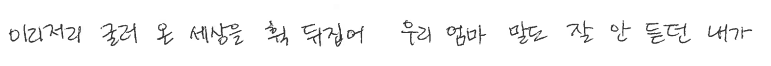
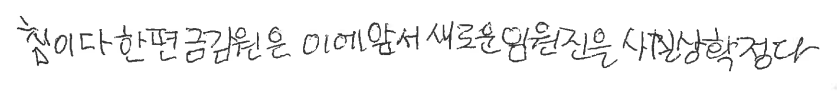
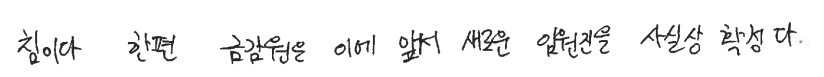
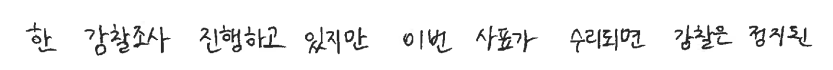
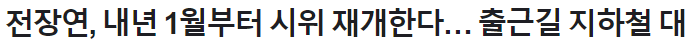
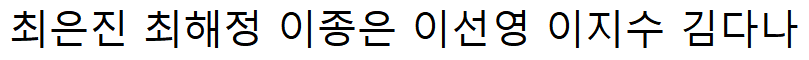

In [ ]:
from IPython.core.display import display, HTML
from PIL import Image
import base64
import io
import pandas as pd

data = pd.DataFrame()
for ind, row in enumerate(ouput[ouput.index('image_path               \tpredicted_labels         \tconfidence score')+2:]):
  row = row.split('\t')
  filename = row[0].strip()
  label = row[1].strip()
  conf = row[2].strip()
  img = Image.open(filename)
  img_buffer = io.BytesIO()
  img.save(img_buffer, format="PNG")
  imgStr = base64.b64encode(img_buffer.getvalue()).decode("utf-8") 

  data.loc[ind, 'img'] = '<img src="data:image/png;base64,{0:s}", width=600>'.format(imgStr)
#   data.loc[ind, 'id'] = filename
  data.loc[ind, 'label'] = label
  data.loc[ind, 'conf'] = conf

html_all = data.to_html(escape=False)
display(HTML(html_all))